In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# 定义一些基础变量

In [2]:
border_ratio=33
image_width=400
image_height=400
tilewidth=0
tileheight=0
TCW=0
TRW=0
restW=0
TCH=0
TRH=0
restH=0

# 一些处理函数

In [ ]:
def sliceway(image,ratio): 
        global tilewidth
        global tileheight
        global TCW
        global TRW
        global restW
        global TCH
        global TRH
        global restH
        rate=ratio/100
        TRW=int(max(rate*min(image[0],image[1])/2,2))
        TRH=TRW
        TCW=int(image[0]/TRW)
        TRW+=int((image[0]-TCW*TRW)/TCW)
        restW=image[0]-TCW*TRW
        TCH=int(image[1]/TRH)
        TRH+=int((image[0]-TCH*TRH)/TCH)
        restH=image[0]-TCH*TRH
        tileheight=2*TRH
        tilewidth=2*TRW




In [ ]:
def GradientRemove(image):
    opt=image
    gradientRGB=np.zeros((2,3))
    for i in range(0,image.shape[0]):
        gradientRGB[0,:]+=(image[i,image_width-1,:]-image[i,0,:])
    for i in range(0,image.shape[1]):
        gradientRGB[1,:]+=(image[image_height-1,i,:]-image[0,i,:])
    gradientRGB[0]/=image_width
    gradientRGB[1]/=image_height
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            tempx=(-0.5+j/(image_width-1))#(-0.5,0.5)
            tempy=(-0.5+i/(image_height-1))#(-0.5,0.5)
            opt[i,j,:]-=tempx*gradientRGB[0,:]+tempy*gradientRGB[1,:]
    return opt

    
    
    



In [ ]:
def getEigenRGB(image):
    expected=np.zeros((4,3))
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            expected[0,:]+=image[i,j,:]
            expected[1,:]+=image[i,j,:]*image[i,j,0]
            expected[2,:]+=image[i,j,:]*image[i,j,1]
            expected[3,:]+=image[i,j,:]*image[i,j,2]
    expected/=image_height*image_width
    COVMAT=np.zeros((3,3))
    #中心化处理
    COVMAT[0,:]=expected[1,:]-expected[0,0]*expected[0,:]
    COVMAT[1,:]=expected[2,:]-expected[0,0]*expected[1,:]
    COVMAT[2,:]=expected[3,:]-expected[0,0]*expected[2,:]
    COVMAT=np.dot(COVMAT.T,COVMAT)
    return np.linalg.eig(COVMAT)

            

In [6]:
def erfinv(x):
    w, p = 0.0, 0.0
    w = -math.log((1.0 - x) * (1.0 + x))
    
    if w < 5.000000:
        w = w - 2.500000
        p = 2.81022636e-08
        p = 3.43273939e-07 + p * w
        p = -3.5233877e-06 + p * w
        p = -4.39150654e-06 + p * w
        p = 0.00021858087 + p * w
        p = -0.00125372503 + p * w
        p = -0.00417768164 + p * w
        p = 0.246640727 + p * w
        p = 1.50140941 + p * w
    else:
        w = math.sqrt(w) - 3.000000
        p = -0.000200214257
        p = 0.000100950558 + p * w
        p = 0.00134934322 + p * w
        p = -0.00367342844 + p * w
        p = 0.00573950773 + p * w
        p = -0.0076224613 + p * w
        p = 0.00943887047 + p * w
        p = 1.00167406 + p * w
        p = 2.83297682 + p * w
    
    return p * x

In [ ]:
def Histo_Gaussian(image):
    Sort=np.zeros((3,image.shape[0]*image.shape[1]-1))
    R=[]
    G=[]
    B=[]
    E,EV=getEigenRGB(image) 
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            R.append({'ii':i,'jj':j,'val':np.dot(image[i,j],EV[0])})
            G.append({'ii':i,'jj':j,'val':np.dot(image[i,j],EV[1])})
            B.append({'ii':i,'jj':j,'val':np.dot(image[i,j],EV[2])})
    R=sorted(R,key=lambda x:x['val'])
    G=sorted(G,key=lambda x:x['val'])
    B=sorted(B,key=lambda x:x['val'])
    opt=np.zeros((image_height,image_width,3))
    for i in range(0,image_width*image_height):
        U=(i+0.5)/(image_height*image_width) 
        Ga= math.sqrt(2.0) * erfinv(2 * U - 1.0)
        opt[R[i]['ii'],R[i]['jj'],0]=Ga    
        opt[G[i]['ii'],G[i]['jj'],1]=Ga   
        opt[B[i]['ii'],B[i]['jj'],2]=Ga   
    return opt,EV
        


In [8]:
def RemapValue(v,l1,h1,l2,h2):
    l=(v-l1)
    v2=l/(h1-l1)*(h2-l2)+l2
    return v2


In [ ]:
def borderChange(image):
    opt=np.zeros((400,400,3))
    for i in range(0,image_height):
        for j in range(0,image_width):
            w=min(RemapValue(j,0,tilewidth/2,0,1),1)
            w*=min(RemapValue(j,image_width-1,image_width-tilewidth/2-1,0,1),1)
            w*=min(RemapValue(i,0,tileheight/2,0,1),1)
            w*=min(RemapValue(i,image_height-1,image_height-tileheight/2-1,0,1),1)
            w=w/math.sqrt(w*w+(1-w)*(1-w)) 
            opt[i,j,:]=w*image[i,j,:]
    return opt

In [10]:
def mod_positive(a,b):
    c=a%b
    if c<0 :
        c+=b
    return c

In [ ]:
def make_tilable_again(image,image2):
    for c in range(-1,TCW+TCH-2):
  
        itile=-1
        jtile=-1
        if c<TCW-1 :
            jtile=c
        else:
            itile=c-TCW+1

        extraW=0
        extraH=0 
        offsetW=0
        offsetH=0 
        if itile>TCW-2-restW : 
            extraW=1
            offsetW=jtile-1-(TCW-2-restW)
        elif jtile>TCH-2-restW :
            extraH=1
            offsetH=itile-1-(TCH-2-restH)
        
        offsetx=math.floor((image_width-(tilewidth+extraW))*np.random.rand()) 
       
        offsety=math.floor((image_height-(tileheight+extraH))*np.random.rand())
        for i in range(0,tileheight+TCH):
            for j in range(0,tilewidth+TCW):
                w=0
               
                if j>=tilewidth/2 and j<tilewidth/2+extraW: 
                    w0=1-math.floor(abs(i-0.5*(tileheight-1)))/(tileheight/2-1)  
                    w=w0/math.sqrt(w0*w0+(1-w0)*(1-w0))
                elif i>=tileheight/2 and i<tileheight/2+extraH: 
                    w0=1-math.floor(abs(j-0.5*(tilewidth-1)))/(tilewidth/2-1)  
                    w=w0/math.sqrt(w0*w0+(1-w0)*(1-w0))
                else :
                    tj=j
                    ti=i
                    if(i>tileheight/2+extraH): 
                        tj=j-extraW
                    if(j>tilewidth/2+extraW):
                        ti=i-extraH
                    lambdax=1-math.floor(abs(tj-0.5*(tilewidth-1)))/(tilewidth/2-1) 
                    lambday=1-math.floor(abs(ti-0.5*(tileheight-1)))/(tileheight/2-1)
                    w00=(1-lambdax)*(1-lambday)
                    w01=(1-lambdax)*(lambday)
                    w10=(lambdax)*(1-lambday)
                    w11=(lambdax)*(lambday)
                    w=lambdax*lambday/math.sqrt(w00*w00+w10*w10+w11*w11+w01*w01)  
                index_i_opt=int(mod_positive(i+itile*tileheight/2+offsetH,image_height))
                index_j_opt=int(mod_positive(j+jtile*tilewidth/2+offsetW,image_width))
                
                index_i_inp=int((i+offsety)%image_height)
                index_j_inp=int((j+offsetx)%image_width)
                image2[index_i_opt,index_j_opt, : ]+=w*image[index_i_inp,index_j_inp,:]

    return image2
        

                


        
    

In [ ]:
def back_to_Histo(image1,image2,EV):
    Sort=np.zeros((3,image2.shape[0]*image2.shape[1]-1))
    R=[]
    G=[]
    B=[]
    for i in range(0,image2.shape[0]):
        for j in range(0,image2.shape[1]):
            R.append({'ii':i,'jj':j,'val':np.dot(image2[i,j],EV[0])})
            G.append({'ii':i,'jj':j,'val':np.dot(image2[i,j],EV[1])})
            B.append({'ii':i,'jj':j,'val':np.dot(image2[i,j],EV[2])})
    R=sorted(R,key=lambda x:x['val'])
    G=sorted(G,key=lambda x:x['val'])
    B=sorted(B,key=lambda x:x['val'])
    opt=np.zeros((image_height,image_width,3))
    for i in range(0,image_height):
        for j in range(0,image_width):
             
            ind=np.zeros(3,dtype=np.int32)
            for k in range(0,3):
                Gauss=image1[i,j,k]
                Unif=0.5+0.5*math.erf(Gauss/math.sqrt(2))
                 
                ind[k]=math.floor(Unif*(image_height*image_width))
             
            opt[i,j,0]=R[ind[0]]['val']
            opt[i,j,1]=G[ind[1]]['val']
            opt[i,j,2]=B[ind[2]]['val']
            rgb=EV[0]*opt[i,j,0]+EV[1]*opt[i,j,1]+EV[2]*opt[i,j,2]
            opt[i,j]=rgb
    return opt
            




# 处理的汇总

In [13]:
output=np.zeros((400,400,3))
input=plt.imread("inp.png")
image_height=input.shape[0]
image_width=input.shape[1]

### 先高斯化

In [14]:
sliceway((image_height,image_width),border_ratio)
input_no_G=GradientRemove(input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.517750506446679..4.517750506446679].


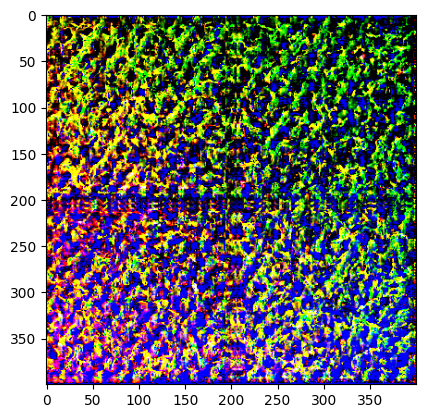

In [15]:
inp2,EV=Histo_Gaussian(input_no_G)
plt.imshow(inp2)

In [16]:
print(EV)

[[ 0.36087934 -0.76510665  0.53327097]
 [ 0.45404557  0.64359973  0.61613473]
 [ 0.81462183 -0.01977903 -0.57965513]]


### 再混合

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.517750506446679..4.517750506446679].


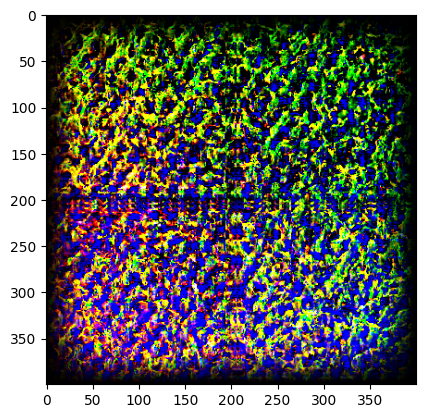

In [17]:
inp3=borderChange(inp2)#将边缘去掉，便于融合
plt.imshow(inp3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.517750506446679..4.517750506446679].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.517750506446679..4.517750506446679].


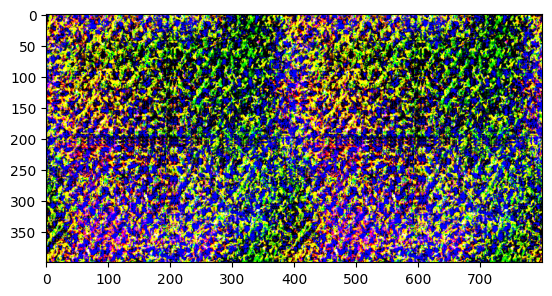

In [18]:
inp4=make_tilable_again(inp2,inp3)
plt.imshow(inp4)
inp5=np.zeros((400,800,3))
inp5[:,:400,:]=inp4
inp5[:,400:,:]=inp4
plt.imshow(inp5)

In [19]:
inp5_2=back_to_Histo(inp4,input_no_G,EV)

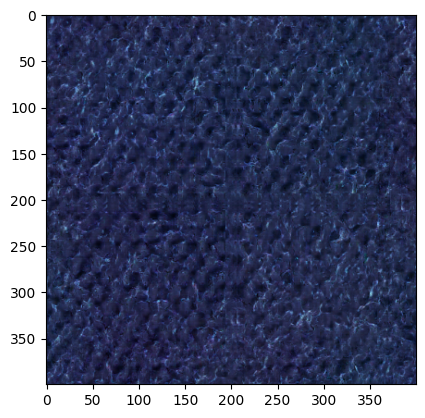

In [20]:
plt.imshow(inp5_2)

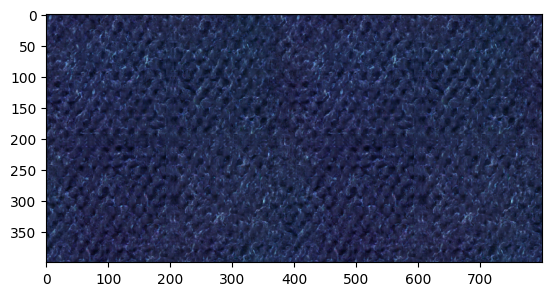

In [21]:
inp5_3=np.zeros((400,800,3))
inp5_3[:,:400,:]=inp5_2
inp5_3[:,400:,:]=inp5_2
plt.imshow(inp5_3)